# Final Capstone Report: Music Trend Forecasting
This report presents the final evaluation of all forecasting models using combined metrics and predictions.


In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os


# Load Combined Metrics and Predictions
metrics_df = pd.read_csv("../outputs/forecasts/combined/combined_model_metrics_REPORT_READY.csv")
predictions_df = pd.read_csv("../outputs/forecasts/combined/combined_model_predictions.csv")

plt.style.use('seaborn-v0_8-whitegrid') # Example style, you can choose others
sns.set_palette('tab10') # Example color palette

metrics_df.head(), predictions_df.head()

top_genres = [
    "pop", "rap_hip_hop", "latin_music", "alternative", "dance",
    "randb", "rock", "electro", "asian_music", "films_games",
    "film_scores", "techno_house", "international_pop", "indie_pop", "singer_and_songwriter"
]

model_column_mapping = {
    "Prophet": "predicted_streams_prophet_best",
    "SARIMA": "predicted_streams_sarima",
    "LightGBM": "predicted_streams_LGBM_tuned_ts_cv",
    "RandomForest": "predicted_streams_RF_tscv_tuned"
}


plot_counter = 1  # Global plot counter

def save_and_show():
    global plot_counter
    os.makedirs('../outputs/plots/Report', exist_ok=True)
    plt.savefig(f'../outputs/plots/Report/plot_{plot_counter:02d}.png', bbox_inches='tight')
    plt.show()
    plot_counter += 1


## RMSE and MAE Comparison Summary Across Genres

### Key Observations:

- **RandomForest consistently achieves the lowest RMSE and MAE across all genres**, reinforcing its position as the most effective model based on absolute error metrics.
- **LightGBM follows closely behind RandomForest**, typically ranking second in both RMSE and MAE for most genres.
- **SARIMA performs moderately well**, outperforming simpler baselines like Naive and MovingAverage but lagging behind tree-based models.
- **Prophet, Naive, and MovingAverage exhibit the worst RMSE and MAE** across nearly all genres, suggesting they are less reliable for minimizing absolute errors.
- **Films_games and rap_hip_hop show extremely high RMSE and MAE for all models**, indicating these genres are particularly difficult to forecast accurately in terms of magnitude.
- These results highlight that **while RandomForest and LightGBM excel at minimizing absolute error**, their performance should still be cross-validated with relative or trend-based metrics to ensure realistic temporal predictions.



--- Generating combined plots for metrics: RMSE, MAE, ordered by MAE ---
Total unique models considered (with complete metrics): 6 (MovingAverage, Prophet, LightGBM, Naive, RandomForest, SARIMA)
Found 10 genres with results from all 6 models for the specified metrics: ['alternative', 'asian_music', 'dance', 'electro', 'films_games', 'latin_music', 'pop', 'randb', 'rap_hip_hop', 'rock']


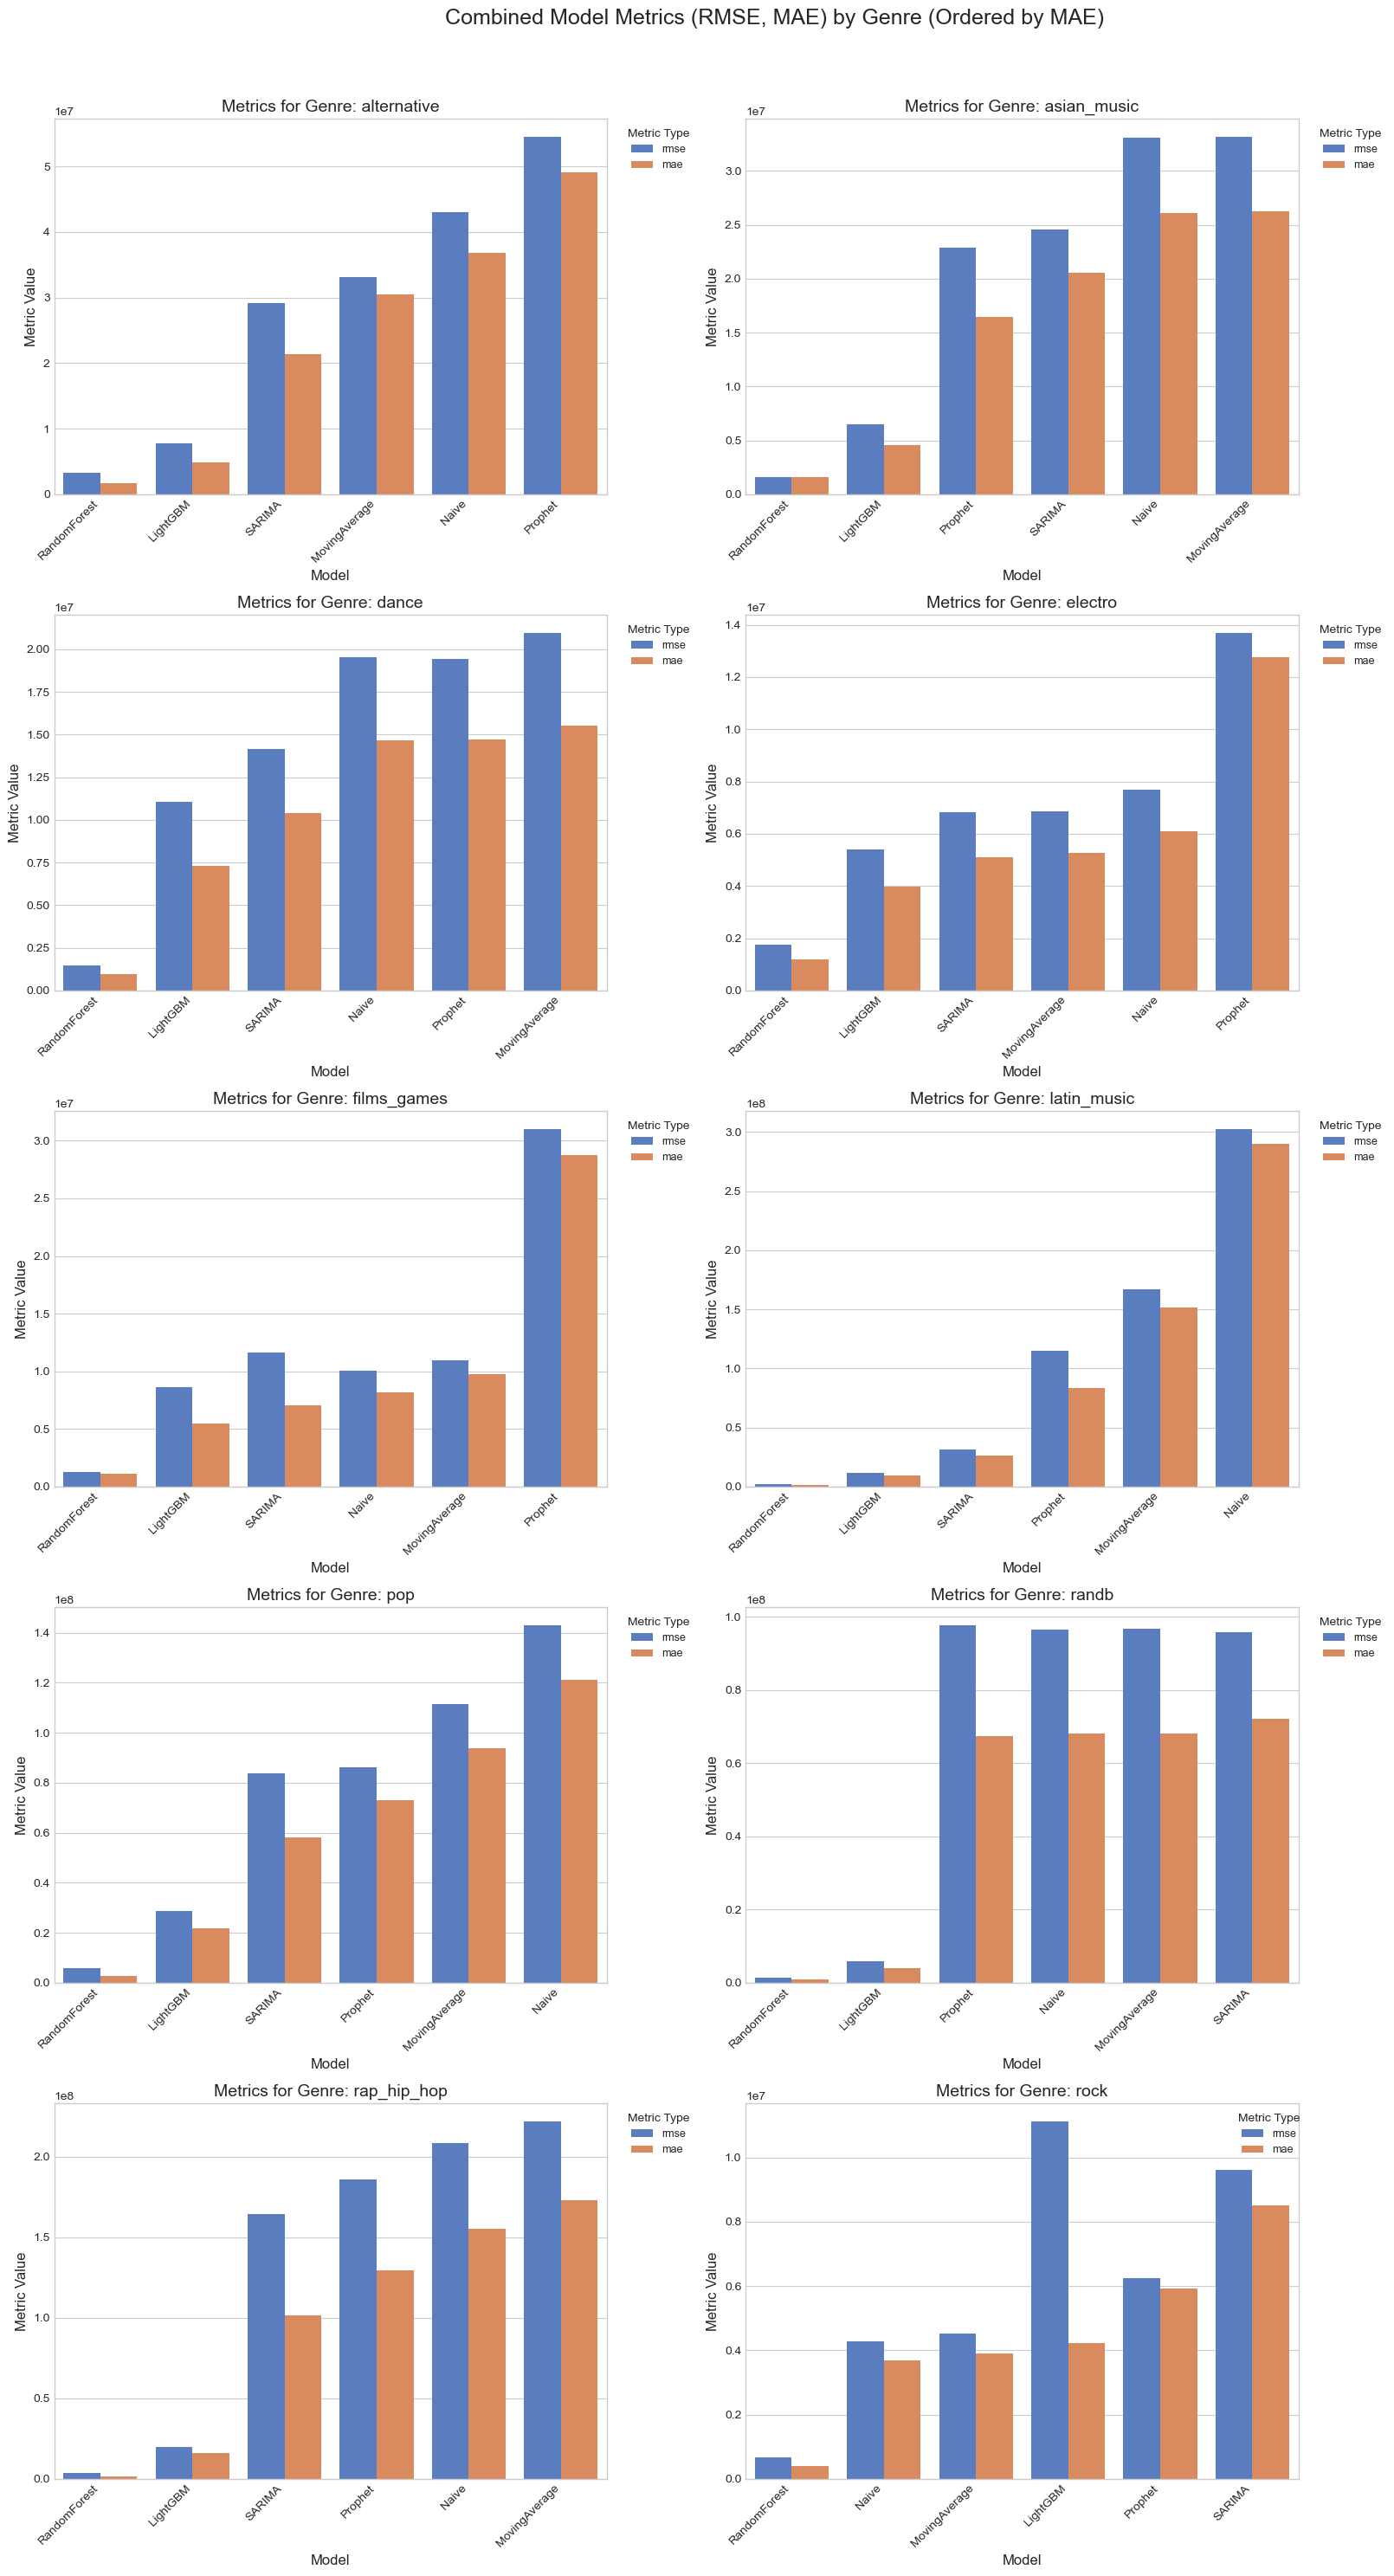


IMPORTANT NOTE ON SCALES: RMSE and MAE are plotted on the same Y-axis in each subplot.
Their absolute values can be different, so direct visual comparison of bar heights *across different metric types* can be misleading.


In [2]:
actual_model_column = 'model_name_extracted'
actual_genre_column = 'genre'

metrics_to_plot_now = ['rmse', 'mae']

def plot_combined_metrics_grid_ordered(metrics_df, metrics_list, model_col_name, genre_col_name, order_by_metric='mae'):
    """
    Generates a grid of grouped bar plots. Each subplot is for a genre.
    Bars are grouped by model, with different metrics (from metrics_list) shown by hue.
    Models within each genre are ordered by the specified 'order_by_metric'.
    Only includes genres that have results from all models for all specified metrics.
    Legend is placed to the right of each subplot.
    """
    if not isinstance(metrics_df, pd.DataFrame):
        print("Error: metrics_df is not a DataFrame. Please load your data correctly.")
        return

    # Ensure the ordering metric is part of the metrics list to be plotted,
    # or at least available in the DataFrame for sorting.
    cols_for_completeness_check = list(set(metrics_list + [order_by_metric]))
    required_cols = [genre_col_name, model_col_name] + cols_for_completeness_check
    
    missing_cols = [col for col in required_cols if col not in metrics_df.columns]
    if missing_cols:
        print(f"Error: The DataFrame 'metrics_df' is missing one or more required columns for plotting/ordering: {', '.join(missing_cols)}.")
        print(f"Available columns: {metrics_df.columns.tolist()}")
        return

    print(f"\n--- Generating combined plots for metrics: {', '.join(m.upper() for m in metrics_list)}, ordered by {order_by_metric.upper()} ---")

    # 1. Filter out rows where any of the specified metrics (or the ordering metric) are NaN
    df_complete_metrics = metrics_df.dropna(subset=cols_for_completeness_check).copy()
    if df_complete_metrics.empty:
        print(f"No rows with complete data for all metrics needed for plotting and ordering ({', '.join(cols_for_completeness_check)}). Cannot proceed.")
        return

    # 2. Identify all unique models from the data that has complete metrics
    all_model_names = df_complete_metrics[model_col_name].unique()
    total_num_models = len(all_model_names)

    if total_num_models == 0:
        print(f"No models found in column '{model_col_name}' after ensuring complete metrics. Cannot proceed.")
        return
    print(f"Total unique models considered (with complete metrics): {total_num_models} ({', '.join(all_model_names)})")

    # 3. Filter for genres that have results from all these models (for all specified metrics for completeness)
    genre_model_counts = df_complete_metrics.groupby(genre_col_name)[model_col_name].nunique()
    genres_to_plot = genre_model_counts[genre_model_counts == total_num_models].index.tolist()

    if not genres_to_plot:
        print(f"No genres found with results from all {total_num_models} models for all metrics: {', '.join(cols_for_completeness_check)}. Cannot create grid plot.")
        return
    print(f"Found {len(genres_to_plot)} genres with results from all {total_num_models} models for the specified metrics: {genres_to_plot}")

    # Use this df for ordering before melting
    filtered_df_for_ordering_and_plotting = df_complete_metrics[df_complete_metrics[genre_col_name].isin(genres_to_plot)]

    # 4. Melt the DataFrame to long format for Seaborn's hue functionality (only for metrics to be plotted)
    melted_df = pd.melt(filtered_df_for_ordering_and_plotting,
                        id_vars=[genre_col_name, model_col_name],
                        value_vars=metrics_list, # Use the provided metrics_list for melting
                        var_name='metric_type',
                        value_name='metric_value')

    # 5. Determine grid dimensions
    n_genres = len(genres_to_plot)
    ncols = 2 # Adjust as needed (e.g., 1 if only a few genres, or 3 for more)
    nrows = int(np.ceil(n_genres / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 9, nrows * 6), squeeze=False)
    axes_flat = axes.flatten()

    for i, current_genre in enumerate(genres_to_plot):
        ax = axes_flat[i]
        
        # Data for this specific genre from the pre-melted, filtered DataFrame (for ordering)
        genre_data_for_ordering = filtered_df_for_ordering_and_plotting[
            filtered_df_for_ordering_and_plotting[genre_col_name] == current_genre
        ]
        
        # Determine order of models by the specified 'order_by_metric' (ascending)
        if order_by_metric in genre_data_for_ordering.columns:
            model_order = genre_data_for_ordering.sort_values(by=order_by_metric)[model_col_name].unique()
        else:
            # Fallback if somehow ordering metric is missing for this subset (should not happen due to earlier checks)
            model_order = genre_data_for_ordering[model_col_name].unique()

        # Data for plotting (melted, specific to current genre)
        genre_specific_melted_data = melted_df[melted_df[genre_col_name] == current_genre]

        if not genre_specific_melted_data.empty:
            sns.barplot(data=genre_specific_melted_data,
                        x=model_col_name,
                        y='metric_value',
                        hue='metric_type',
                        order=model_order, # Apply the determined order
                        ax=ax,
                        errorbar=None,
                        palette="muted")
            ax.set_title(f"Metrics for Genre: {current_genre}", fontsize=14)
            ax.set_xlabel("Model", fontsize=12)
            ax.set_ylabel("Metric Value", fontsize=12)
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
            ax.tick_params(axis='y', labelsize=10)
            ax.legend(title='Metric Type', fontsize=9, bbox_to_anchor=(1.02, 1))
        else:
            ax.set_title(f"No plottable (melted) data for Genre: {current_genre}")
            ax.axis('off')

    # Hide any unused subplots
    for j in range(n_genres, nrows * ncols):
        axes_flat[j].axis('off')

    fig.tight_layout(rect=[0, 0, 0.90, 0.96])
    fig.suptitle(f"Combined Model Metrics ({', '.join(m.upper() for m in metrics_list)}) by Genre (Ordered by {order_by_metric.upper()})", fontsize=18, y=0.99)
    save_and_show()
    
    if 'rmse' in metrics_list and 'mae' in metrics_list: # If both are plotted
        print("\nIMPORTANT NOTE ON SCALES: RMSE and MAE are plotted on the same Y-axis in each subplot.")
        print("Their absolute values can be different, so direct visual comparison of bar heights *across different metric types* can be misleading.")

# --- Call the function ---

if 'metrics_df' in locals() and isinstance(metrics_df, pd.DataFrame):
    plot_combined_metrics_grid_ordered(metrics_df,
                                       metrics_list=metrics_to_plot_now, # Now ['rmse', 'mae']
                                       model_col_name=actual_model_column,
                                       genre_col_name=actual_genre_column,
                                       order_by_metric='mae') # Explicitly order by MAE
else:
    print("Error: DataFrame 'metrics_df' not found or is not a DataFrame. Please ensure it is loaded correctly.")

## MAPE Comparison Summary Across Genres

### Key Observations:

- **RandomForest again leads in most genres**, achieving **the lowest MAPE**, confirming it balances both absolute and relative error well.
- **SARIMA shows strong MAPE performance**, outperforming other models in genres like `pop`, `rock`, and `latin_music`, despite higher RMSE/MAE.
- **LightGBM ranks inconsistently**, achieving low MAPE in some genres but **performing poorly in others**, particularly **`films_games`, `latin_music`, and `pop`** where it ranks among the worst.
- **MovingAverage and Naive models again perform poorly** on MAPE across most genres, especially **`films_games` and `latin_music`**, where their relative errors skyrocket.
- **Prophet is the weakest performer in MAPE**, consistently ranking last or near-last in most genres.
- Overall, these results suggest that **RandomForest and SARIMA** provide the **best balance between minimizing both magnitude and relative errors**, while **LightGBM's MAPE instability warrants caution despite its strong RMSE/MAE scores**.



--- Generating combined plots for metrics: MAPE, ordered by MAPE ---
Total unique models considered (with complete metrics): 6 (MovingAverage, Prophet, LightGBM, Naive, RandomForest, SARIMA)
Found 10 genres with results from all 6 models for the specified metrics: ['alternative', 'asian_music', 'dance', 'electro', 'films_games', 'latin_music', 'pop', 'randb', 'rap_hip_hop', 'rock']


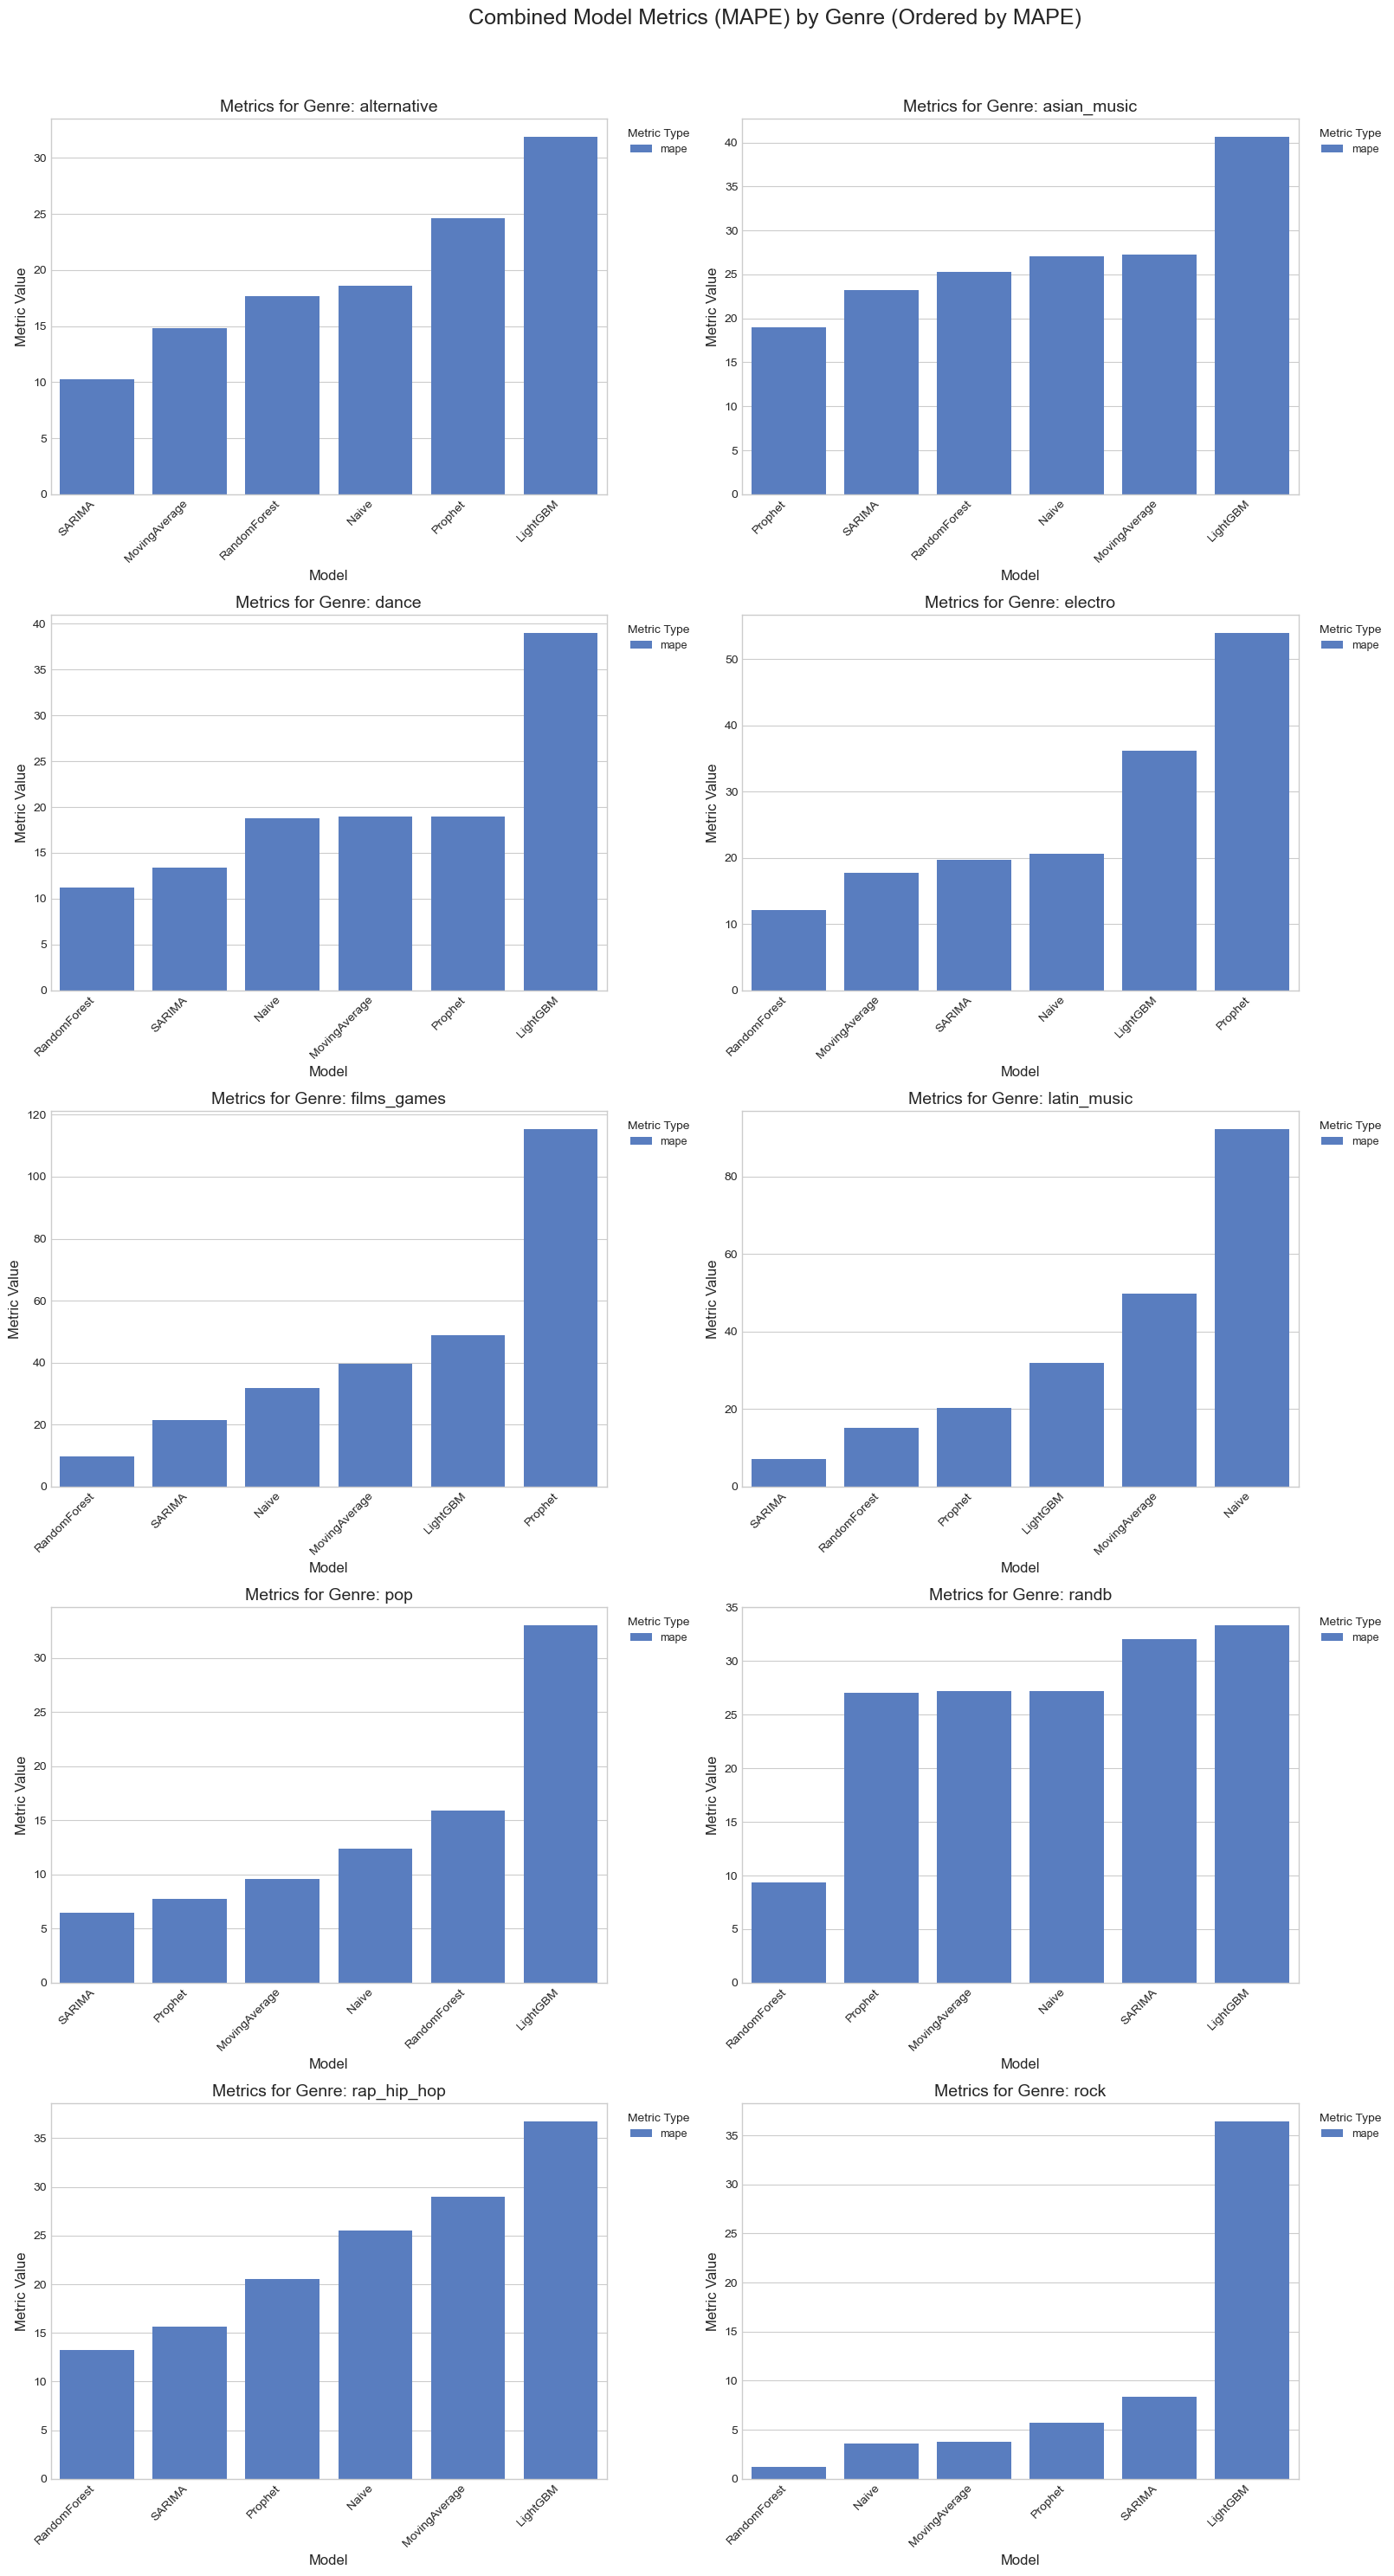

In [3]:
metrics_to_plot_for_mape_chart = ['mape']


# --- Call the function specifically for MAPE ---
if 'metrics_df' in locals() and isinstance(metrics_df, pd.DataFrame):
    if 'mape' in metrics_df.columns: # Check if 'mape' column exists
        plot_combined_metrics_grid_ordered(metrics_df,
                                           metrics_list=metrics_to_plot_for_mape_chart, # Should be ['mape']
                                           model_col_name=actual_model_column,
                                           genre_col_name=actual_genre_column,
                                           order_by_metric='mape') # Order by MAPE
    else:
        print("Error: Column 'mape' not found in metrics_df. Cannot generate MAPE plot.")
        print(f"Available columns: {metrics_df.columns.tolist()}")
else:
    print("Error: DataFrame 'metrics_df' not found or is not a DataFrame. Please ensure it is loaded correctly.")

## Actual vs Predicted for Top 10 Genres

## Key Observations on Actual vs. Predicted Genre-Level Streams

### Pop
- SARIMA tracks the overall trend reasonably well.
- Both LightGBM and RandomForest significantly underestimate streams.

### Rap/Hip Hop
- SARIMA moderately follows the trend with some lag.
- Prophet and LightGBM provide nearly flat forecasts.
- RandomForest consistently underestimates.

### Latin Music
- SARIMA overestimates the decline but generally captures the downward trend.
- LightGBM again performs poorly, with significantly lower and static forecasts.

### Alternative
- SARIMA provides a decent fit with some delay in responding to changes.
- LightGBM provides a great fit without delay.

### Dance
- SARIMA captures parts of the trend but lags during sharp increases.
- LightGBM and RandomForest produce lower forecasts that have a similar shape but underestimate.

### R&B
- SARIMA reacts to peaks but overestimates and has lag.
- LightGBM and RandomForest consistently under-predict, with RandomForest particularly low and flat.

### Rock
- SARIMA peaks when the actual dips, and dips when the actual peaks.
- Prophet generally follows the shape of the actual streams.
- LightGBM follows the trend the best and is most similar to the actual.

### Electro
- SARIMA shows responsiveness but lags.
- Prophet stays flat and unresponsive.
- LightGBM follows the shape but  underestimates.

### Asian Music
- SARIMA lags again  but follows the shape.
- Random Forest is missing because of the scarcity of points.

### Films & Games
- most closely followed by Sarime, but with differences.
- Prophet remains flat but higher than other models.
- LightGBM is overestimating and suddenly drop and underestimates.

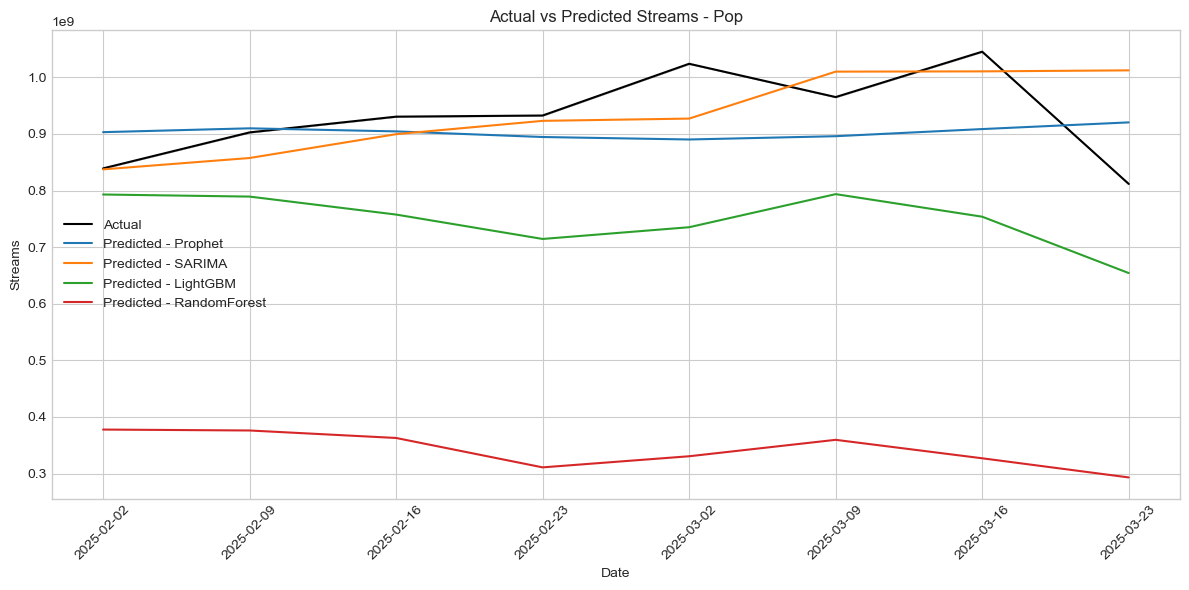

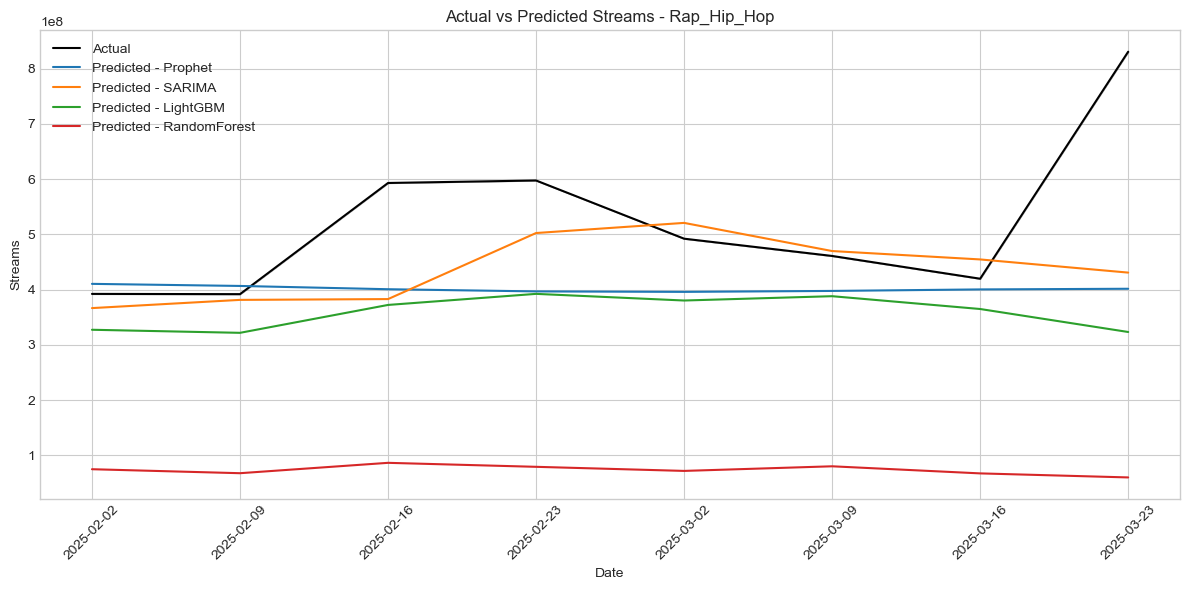

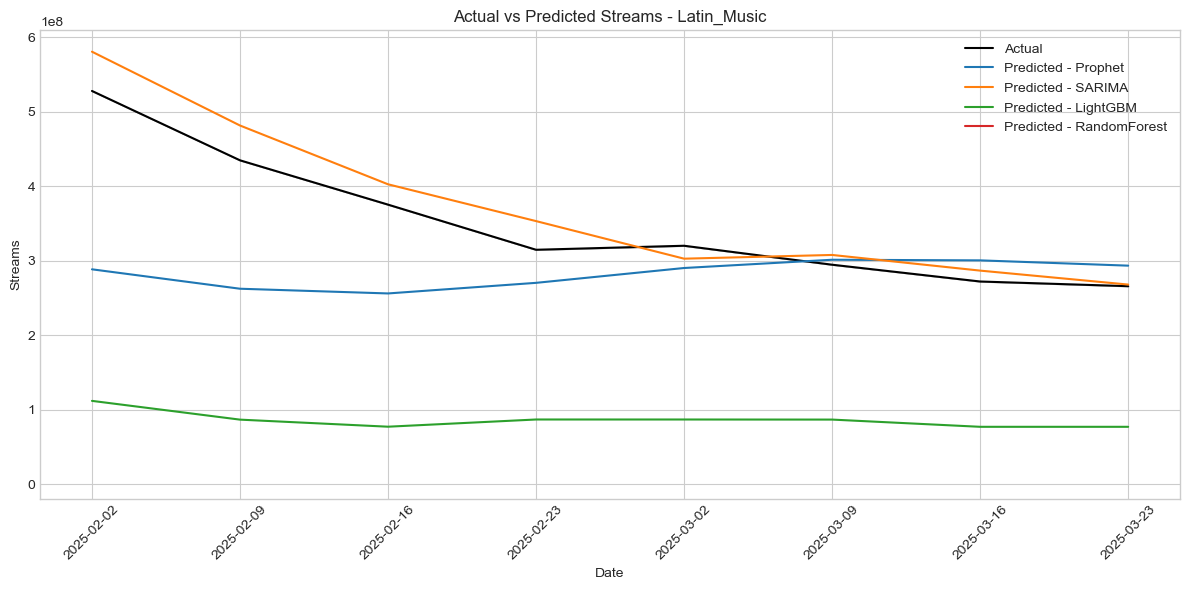

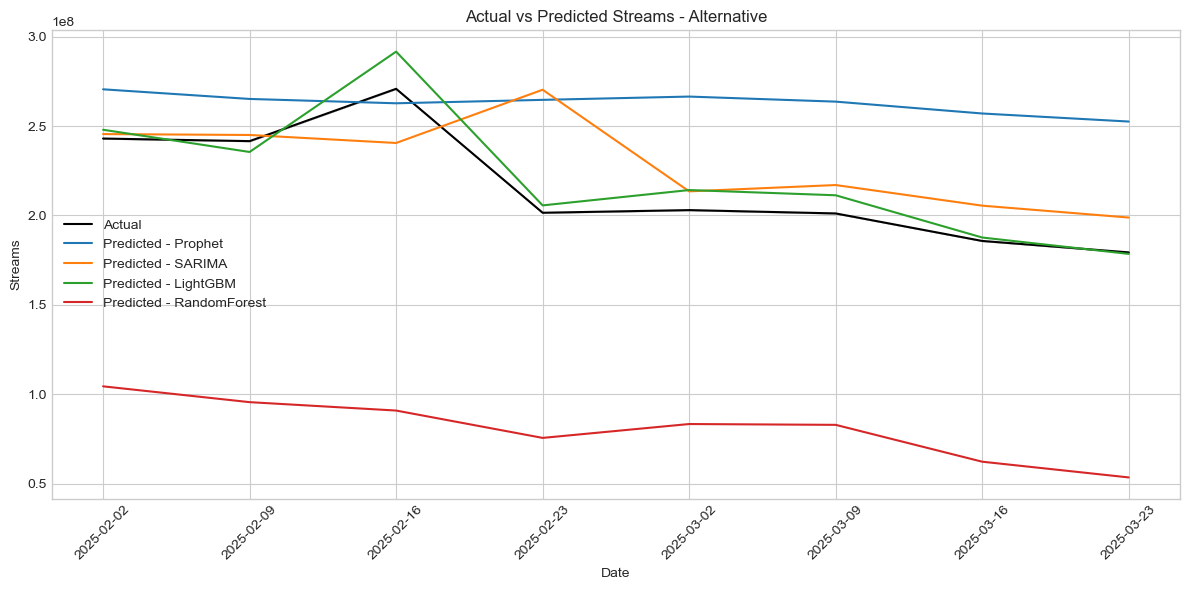

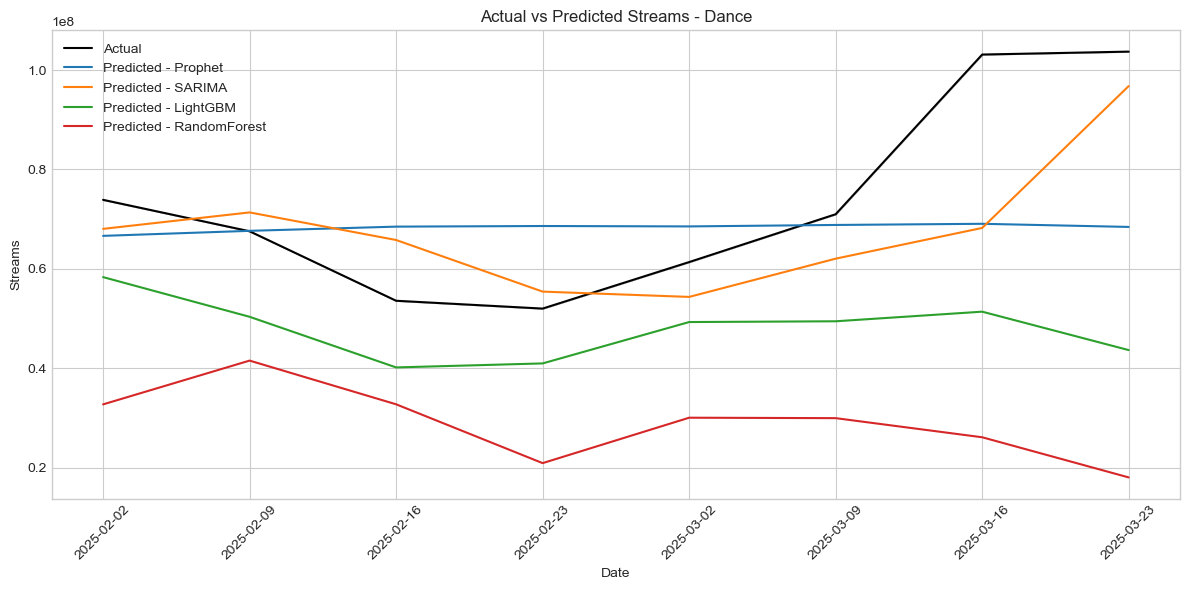

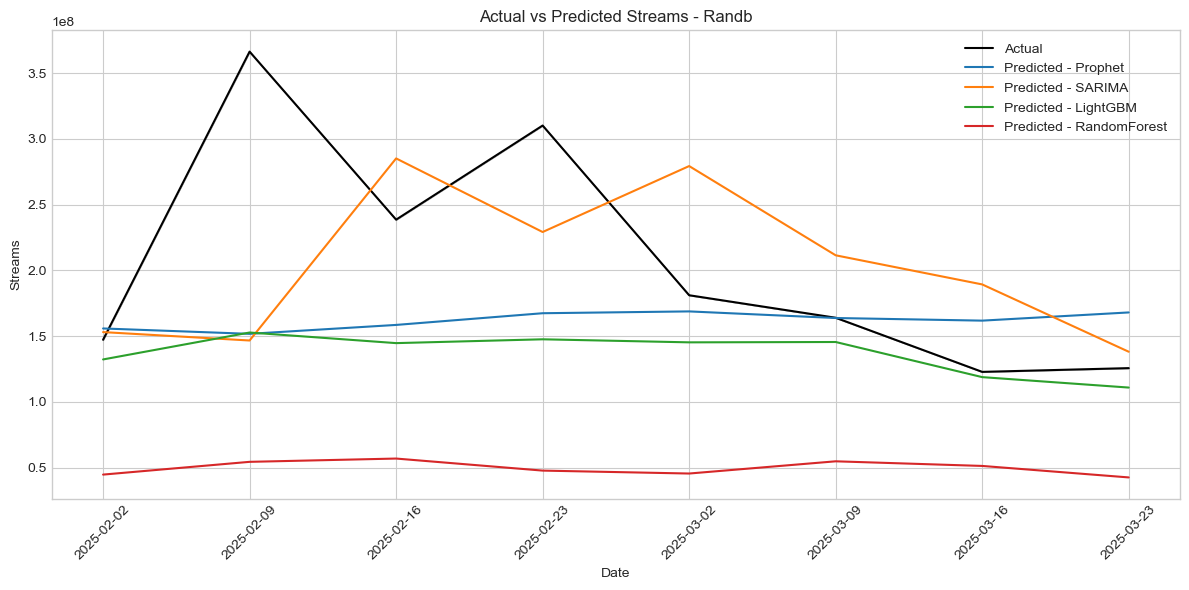

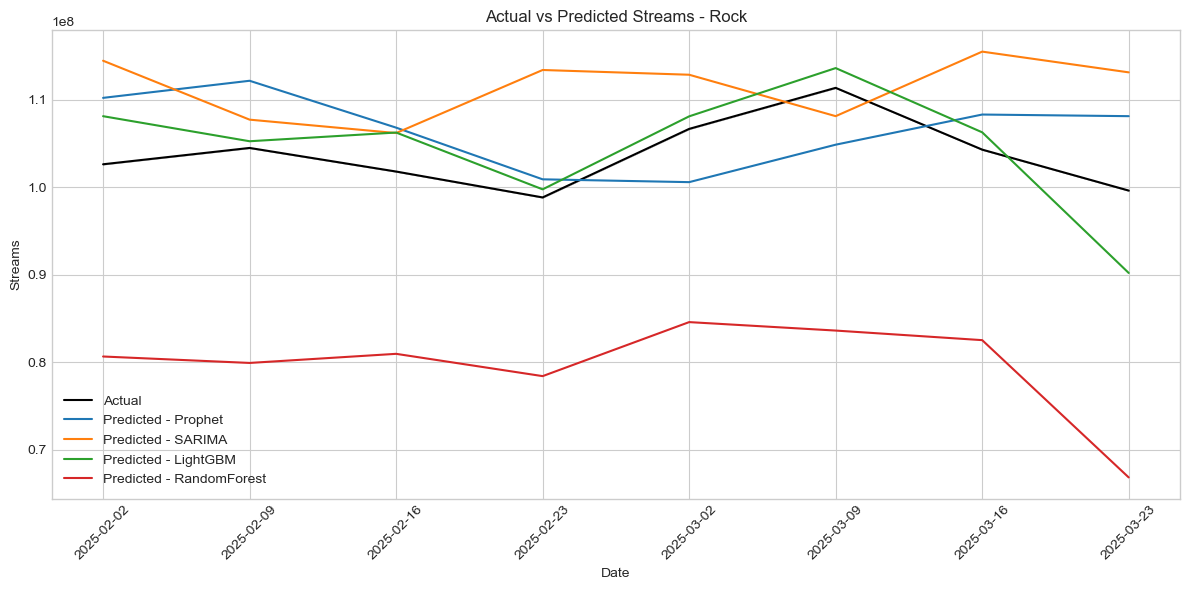

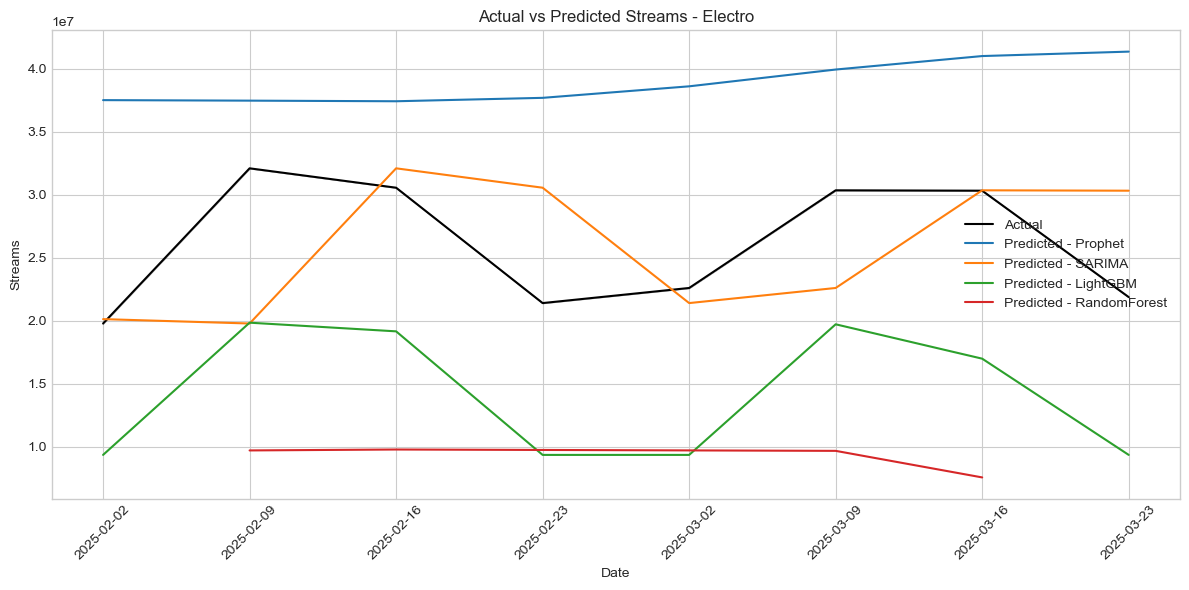

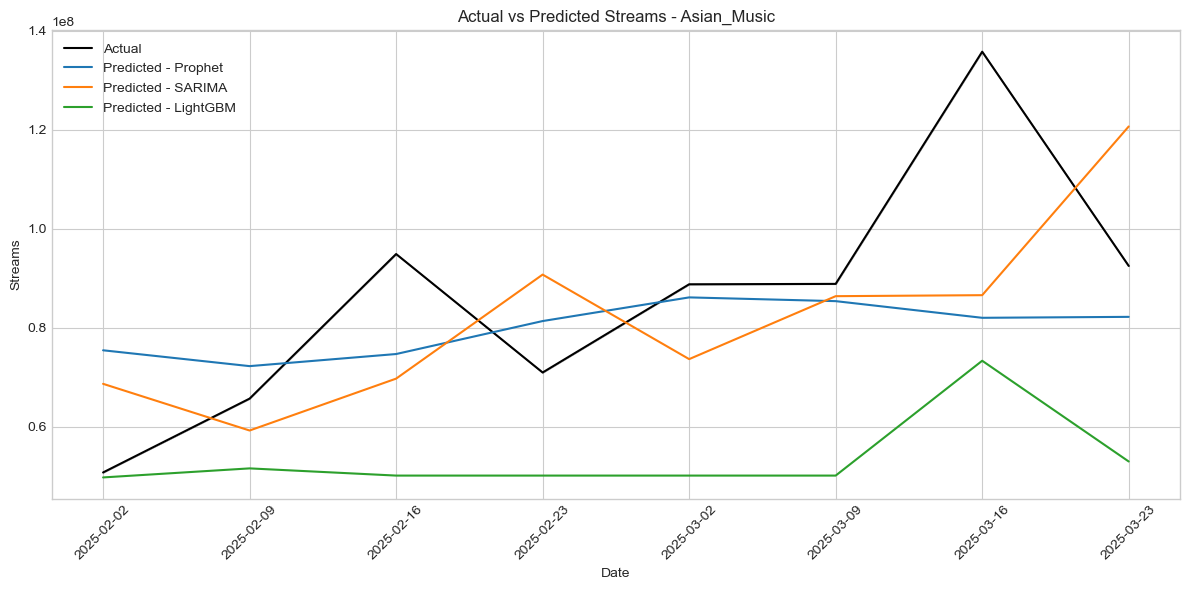

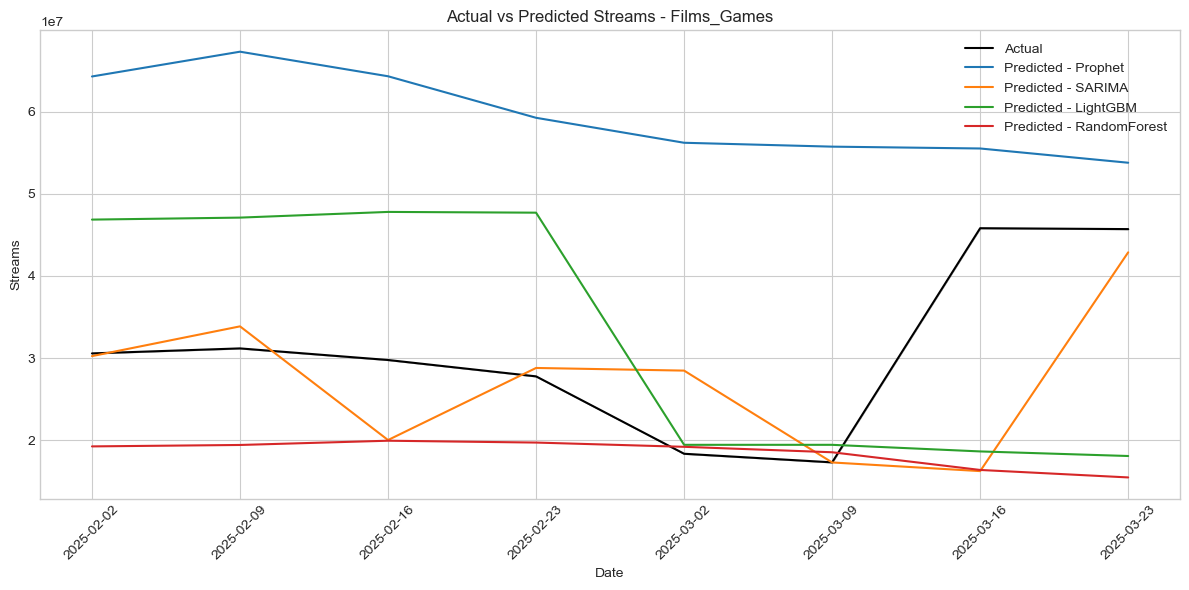

Skipping film_scores: no actual stream data.
Skipping techno_house: no actual stream data.
Skipping international_pop: no actual stream data.
Skipping indie_pop: no actual stream data.
Skipping singer_and_songwriter: no actual stream data.


In [4]:
model_column_mapping = {
    "Prophet": "predicted_streams_prophet_best",
    "SARIMA": "predicted_streams_sarima",
    "LightGBM": "predicted_streams_LGBM_tuned_ts_cv",
    "RandomForest": "predicted_streams_RF_tscv_tuned"
}

for genre in top_genres:
    df_genre = predictions_df[predictions_df['genre'] == genre].sort_values('date')
    
    if df_genre['actual_streams'].dropna().empty:
        print(f"Skipping {genre}: no actual stream data.")
        continue

    # Plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_genre, x="date", y="actual_streams", label="Actual", color="black")
    plotted_models = []
    for model, col in model_column_mapping.items():
        if col in df_genre.columns and not df_genre[col].dropna().empty:
            sns.lineplot(data=df_genre, x="date", y=col, label=f"Predicted - {model}")
            plotted_models.append(model)

    if plotted_models:
        plt.title(f"Actual vs Predicted Streams - {genre.title()}")
        plt.xticks(rotation=45)
        plt.ylabel("Streams")
        plt.xlabel("Date")
        plt.legend(loc='best')
        plt.tight_layout()
        save_and_show()

    else:
        plt.close()
        print(f"Skipping {genre}: no predictions available.\n")


## DTW Distance Comparison Across Models and Genres

The bar chart below summarizes the Dynamic Time Warping (DTW) distances computed for each model across the top 10 genres. DTW is a temporal similarity metric that measures how well the predicted stream trajectories align with the actual stream trajectories, regardless of absolute scale. **Lower DTW values indicate better shape alignment.**

### Key Observations:

- **SARIMA and Prophet** generally achieve **lower DTW distances**, suggesting they are better at following the overall shape of the actual stream patterns, even if their scale may not perfectly match.
- **LightGBM and RandomForest** tend to have **higher DTW distances** in most genres, indicating they struggle more with replicating the temporal shape of the actual series, despite potentially achieving low RMSE or MAPE in scalar terms.
- **Genre-specific observations:**
  - For **Pop**, SARIMA performs best, with all other models showing higher DTW.
  - For **Dance**, SARIMA again achieves the lowest DTW, closely followed by Prophet.
  - For **Rock**, most models perform similarly, but SARIMA slightly outperforms others.
  - **Electro** and **Films/Games** genres show small DTW distances across all models, possibly due to lower variability in the actual series.

This analysis puts a number to what was observed in the last plots and shows that the RMSE and MAPE can me missleading if getting the right shape is what is important.

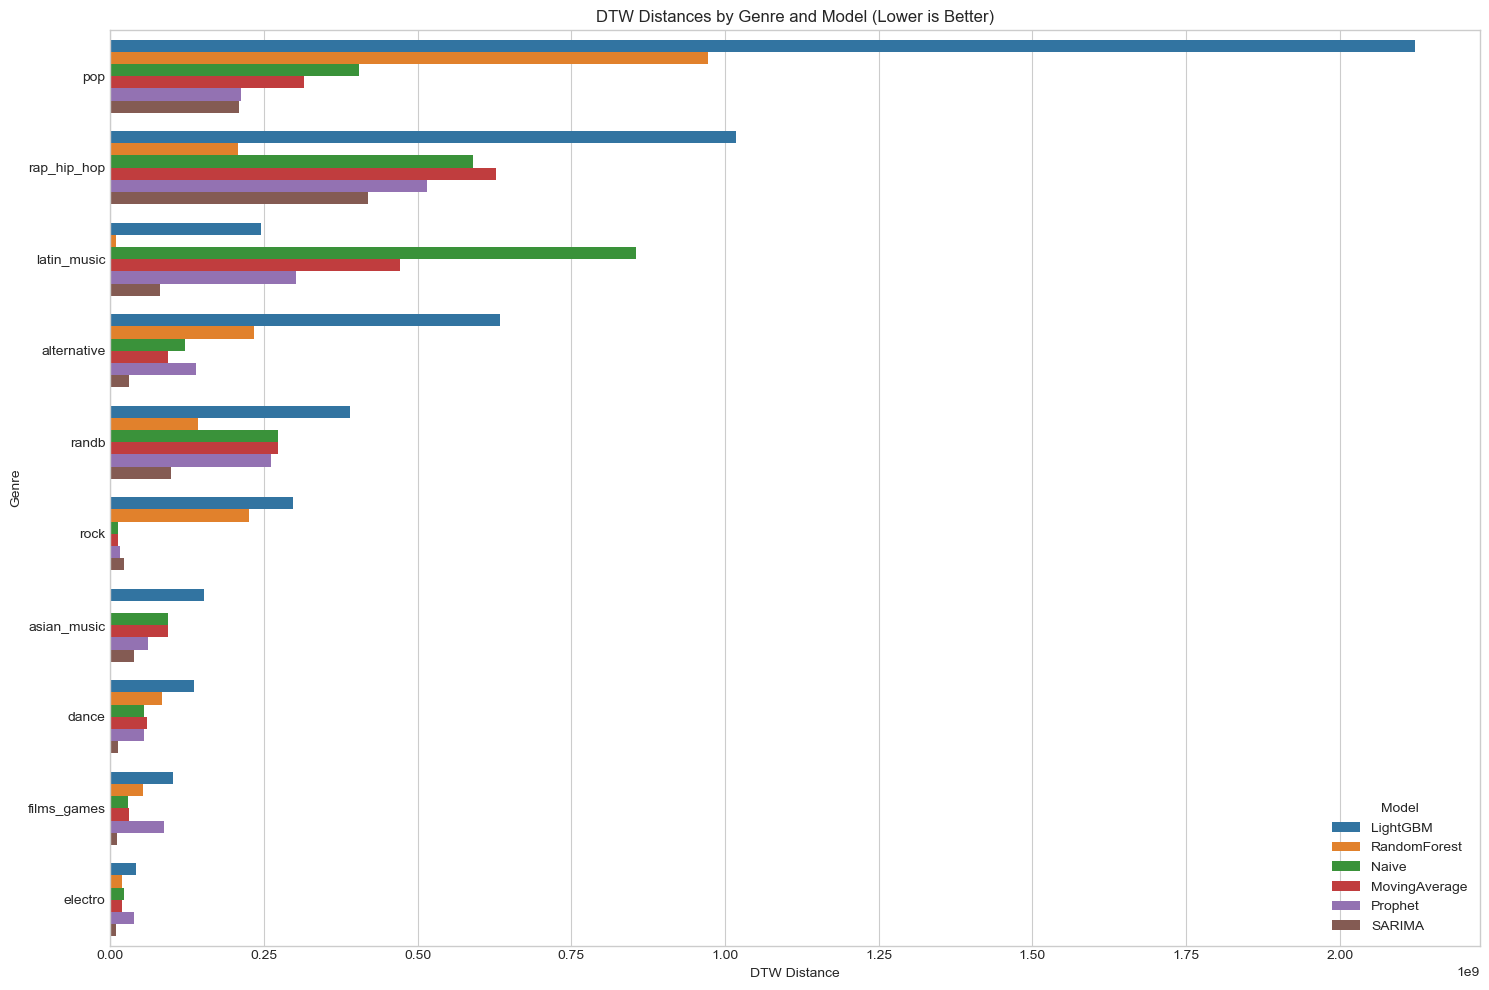

In [5]:
dtw_df = pd.read_csv("../outputs/forecasts/combined/dtw_distances.csv")

dtw_df_sorted = dtw_df.sort_values(by="dtw_distance", ascending=False)

plt.figure(figsize=(15, 10))
sns.barplot(data=dtw_df_sorted, x="dtw_distance", y="genre", hue="model")

plt.title("DTW Distances by Genre and Model (Lower is Better)")
plt.xlabel("DTW Distance")
plt.ylabel("Genre")
plt.legend(title="Model", loc="best")
plt.tight_layout()
save_and_show()

## ✅ Final Conclusions

1. **Best Performing Models**  
   - **SARIMA** demonstrated the most consistent performance, achieving the best **temporal alignment** with actual streaming patterns based on **low DTW distances** while maintaining competitive **relative error (MAPE)** across most genres.
   - **RandomForest** excelled in reducing **magnitude-based errors** (low RMSE and MAE), although its forecasts were often overly flat or lagged in shape.

2. **Model Limitations**  
   - **LightGBM** and **RandomForest** tended to produce **flattened trends**, capturing the general level of streams but failing to follow short-term dynamics.
   - **Prophet**, **Naive**, and **MovingAverage** consistently showed the weakest performance across both magnitude and shape metrics.

3. **Key Observations from Temporal Shape Analysis**  
   - **SARIMA** and **Prophet** better preserved the **temporal structure** of stream fluctuations, as indicated by their superior **DTW scores**.
   - **LightGBM** and **RandomForest**, while numerically accurate, failed to capture **genre-specific dynamics** and transitions over time.

4. **Genre Forecasting Difficulty**  
   - **Films_Games** and **Latin_Music** emerged as the **most challenging genres**, showing high error across all evaluated models.

5. **Final Summary**  
   - **SARIMA** is the most balanced choice for genre-level forecasting when both **trend fidelity** and **error minimization** are considered.
   - **RandomForest** remains a strong candidate when the focus is solely on **reducing absolute forecast error**.
   - **Prophet, Naive, and MovingAverage** models are **not recommended** for production use based on consistently poor results across all evaluation criteria.

---

**End of Final Report**
